## Team 2413:
- Maryam Gholami Shiri (2013071)
- Muhammad Usama Qasim (2040472)
- Laura Schulze (2122311)
- Savina Tsichli (10738280)

# Exercise 4: Restricted Boltzmann Machines (RBMs)
We want to study the performances of an RBM, and, by looking at its learned weights and biases,
better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104
configurations with L=10 bits). Use an RBM with M=3 hidden units.

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

## 4.1 
Increase the number of contrastive divergence steps from n=1 to n=5.

(10000, 10)
Training with 1 CD steps...


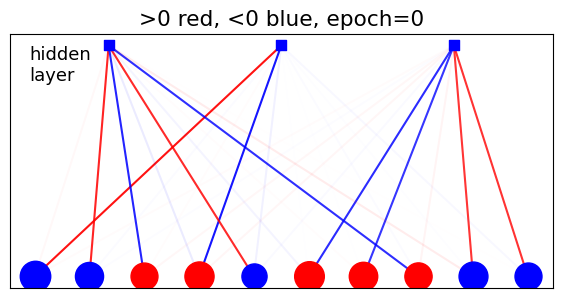

Training with 2 CD steps...


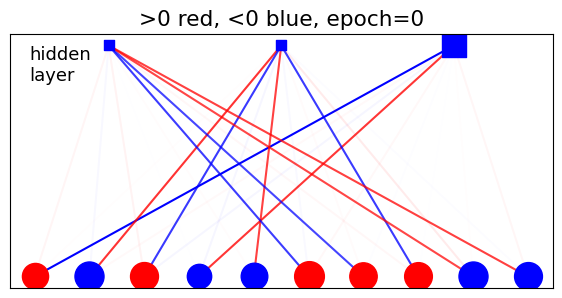

Training with 3 CD steps...


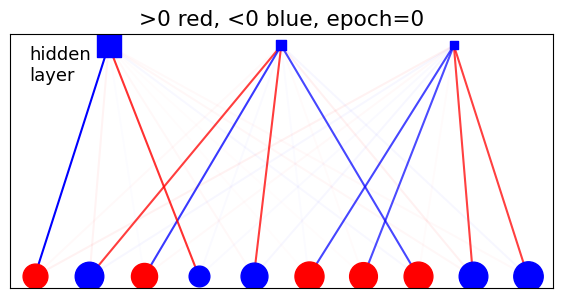

Training with 4 CD steps...


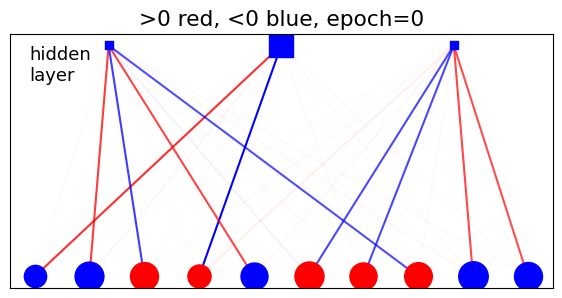

Training with 5 CD steps...


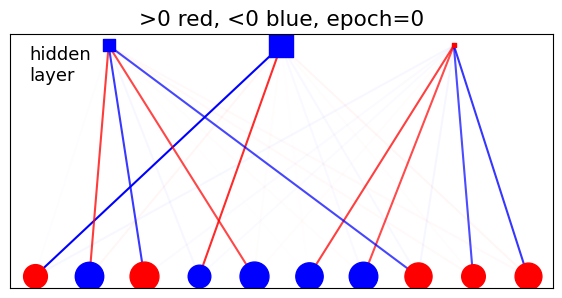

In [2]:
# Load data
data = np.loadtxt('x_RBM_2024_exercise.dat')
print(data.shape)

# Initialize RBM Parameters
L = 10  # Number of visible units
M = 3   # Number of hidden units
W = np.random.randn(L, M)  # Weight matrix
b_visible = np.zeros(L)     # Visible bias
b_hidden = np.zeros(M)      # Hidden bias

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Contrastive Divergence (CD) training with multiple steps
def CD_train(data, W, b_visible, b_hidden, learning_rate=0.1, k=1):
    num_data = len(data)
    for _ in range(k):
        # Positive phase
        positive_hidden = sigmoid(np.dot(data, W) + b_hidden)
        positive_associations = np.dot(data.T, positive_hidden)

        # Negative phase
        negative_visible = np.random.binomial(1, sigmoid(np.dot(positive_hidden, W.T) + b_visible))
        negative_hidden = sigmoid(np.dot(negative_visible, W) + b_hidden)
        negative_associations = np.dot(negative_visible.T, negative_hidden)

        # Update parameters
        W += learning_rate * ((positive_associations - negative_associations) / num_data)
        b_visible += learning_rate * np.mean(data - negative_visible, axis=0)
        b_hidden += learning_rate * np.mean(positive_hidden - negative_hidden, axis=0)

# Training Loop for different numbers of CD steps
epochs = 100          # Number of epochs
batch_size = 32       # Batch size
num_batches = len(data) // batch_size
n_steps_range = range(1, 6)  # Range of CD steps

for n_steps in n_steps_range:
    print(f"Training with {n_steps} CD steps...")
    W = np.random.randn(L, M)  # Reinitialize weights for each set of CD steps

    w = []  # To store weights at each epoch
    for epoch in range(epochs):
        # Shuffle the data for each epoch
        np.random.shuffle(data)
        
        for batch_idx in range(num_batches):
            batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            
            # Update RBM parameters using CD with multiple steps
            CD_train(batch_data, W, b_visible, b_hidden, k=n_steps)
        
        # Save the weights at the end of each epoch
        w.append(W.copy())

    # Plotting the weights of the RBM after training for each set of CD steps
    w = np.array(w)

    def create_coord(np, x0, f=1.0):
        x = [x0] * np
        y = list(range(np))
        for i in range(np):
            y[i] = f * (y[i] / (np - 1.) - 0.5)
        return (x, y)

    (x1, y1) = create_coord(L, 0)
    (x2, y2) = create_coord(M, 1, f=0.7)

    def mycolor(val):
        if val > 0:
            return 'red'
        elif val < 0:
            return 'blue'
        else:
            return 'black'

    def plotgraph(epoch=0):
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.3))
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

        A = 1. / max(w.max(), -w.min())
        for i in range(L):
            for j in range(M):
                ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), mycolor(w[-1, i, j])
                ax.plot(ex, ey, col, zorder=1, alpha=A * abs(w[-1, i, j]))

        A = 300.
        for i in range(L):
            ax.scatter(y1[i], x1[i], s=A * abs(b_visible[i]), zorder=2, c=mycolor(b_visible[i]))

        for j in range(M):
            ax.scatter(y2[j], x2[j], s=min(300, A * abs(b_hidden[j])), zorder=2, c=mycolor(b_hidden[j]), marker="s")

        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51, 0.85, "hidden\nlayer")
        plt.show()

    plotgraph()


## 4.2
Compute the log-likelihood $\mathscr{L}$ during the training, at every epoch, or every minibatch update if it reaches a maximum already in the first epoch. Use “t” as an index of this “time”, indicating the unit in the figures.

(10000, 10)
Epoch 1, Log-Likelihood: -2.5035764817125195
Epoch 2, Log-Likelihood: -3.6131020043226068
Epoch 3, Log-Likelihood: -4.669019105421051
Epoch 4, Log-Likelihood: -7.036179315139487
Epoch 5, Log-Likelihood: -7.469151198730722
Epoch 6, Log-Likelihood: -6.127789990306908
Epoch 7, Log-Likelihood: -8.645548438523452
Epoch 8, Log-Likelihood: -7.522971033030535
Epoch 9, Log-Likelihood: -4.184482868499186
Epoch 10, Log-Likelihood: -5.723539590696976
Epoch 11, Log-Likelihood: -4.685209485739257
Epoch 12, Log-Likelihood: -7.165553950887569
Epoch 13, Log-Likelihood: -9.1111595398029
Epoch 14, Log-Likelihood: -6.465935004340459
Epoch 15, Log-Likelihood: -5.751140477626835
Epoch 16, Log-Likelihood: -8.677179947051187
Epoch 17, Log-Likelihood: -5.854261301892764
Epoch 18, Log-Likelihood: -7.5752693969533595
Epoch 19, Log-Likelihood: -6.0052729012700174
Epoch 20, Log-Likelihood: -6.658610320568039
Epoch 21, Log-Likelihood: -7.23432192572331
Epoch 22, Log-Likelihood: -5.438658984532234
Epoch 

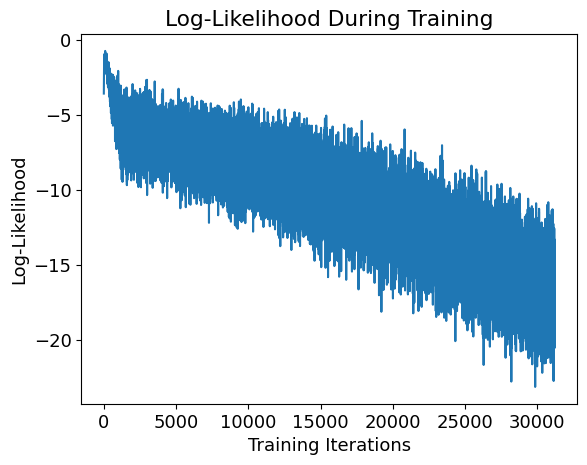

In [3]:
import numpy as np

# Load data
data = np.loadtxt('x_RBM_2024_exercise.dat')
print(data.shape)

# Initialize RBM Parameters
N_visible = 10  # Number of visible units
N_hidden = 3    # Number of hidden units
W = np.random.randn(N_visible, N_hidden)  # Weight matrix
b_visible = np.zeros(N_visible)           # Visible bias
b_hidden = np.zeros(N_hidden)             # Hidden bias

# Define the log-likelihood function
def log_likelihood(data, W, b_visible, b_hidden):
    energy = np.sum(-np.dot(data, b_visible)[:, np.newaxis] - np.log(1 + np.exp(np.dot(data, W) + b_hidden)), axis=1)
    return np.mean(energy)

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Contrastive Divergence (CD) training
def CD_train(data, W, b_visible, b_hidden, learning_rate=0.1, k=1):
    num_data = len(data)
    # Positive phase
    positive_hidden = sigmoid(np.dot(data, W) + b_hidden)
    positive_associations = np.dot(data.T, positive_hidden)

    # Negative phase
    negative_visible = np.random.binomial(1, sigmoid(np.dot(positive_hidden, W.T) + b_visible))
    for i in range(k):
        negative_hidden = sigmoid(np.dot(negative_visible, W) + b_hidden)
        negative_visible = np.random.binomial(1, sigmoid(np.dot(negative_hidden, W.T) + b_visible))
    negative_associations = np.dot(negative_visible.T, negative_hidden)

    # Update parameters
    W += learning_rate * ((positive_associations - negative_associations) / num_data)
    b_visible += learning_rate * np.mean(data - negative_visible, axis=0)
    b_hidden += learning_rate * np.mean(positive_hidden - negative_hidden, axis=0)

# Training Loop
epochs = 100  # Number of epochs
batch_size = 32  # Batch size
num_batches = len(data) // batch_size

log_likelihoods = []

for epoch in range(epochs):
    # Shuffle the data for each epoch
    np.random.shuffle(data)
    
    for batch_idx in range(num_batches):
        batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        
        # Update RBM parameters using CD
        CD_train(batch_data, W, b_visible, b_hidden)
        
        # Compute log-likelihood after each minibatch update
        ll = log_likelihood(batch_data, W, b_visible, b_hidden)
        log_likelihoods.append(ll)
    print(f"Epoch {epoch+1}, Log-Likelihood: {ll}")

# Plot log-likelihood over time
import matplotlib.pyplot as plt

plt.plot(log_likelihoods)
plt.xlabel('Training Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During Training')
plt.show()

## 4.3
Try RBMs with different numbers of hidden units: M=1, 2, 3 (done above), 4, 5, and 6.

some helper functions:

In [4]:
# from the lecture: 
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    #print(x)
    y=list(range(np))
    if np > 1: # to avoid division by 0 for M=1
        for i in range(np):
            y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
    
def activate(v_in,wei,bias,DE=1,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, 0, dtype=int) # a list 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

# let's write functions for plotting & to initialize and train the RBM
def create_plot(w, a, b, epoch=0):
    # get correct shape from weights
    L, M = w.shape
    # define coordinate grid
    (x1,y1)=create_coord(L,0)
    (x2,y2)=create_coord(M,1,f=0.7)

    # plot graph
    # just like the plotgraph function
    # but this time with the correct L and M
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
    
def init_RBM(v, M=3):
    L = len(v[1])
    # range of each initial weight
    sigma = sqrt(4. / float(L + M))
    # random seed for reproducibility
    np.random.seed(12345)
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(L,M)
    a = sigma * np.random.randn(L)
    b = np.zeros(M)
    print("w=",w);print("a=",a);print("b=",b)
    return w, a, b

def run_RBM(v, M=3, l_rate = 1.0, showIntermediatePlots=True):
    N = len(v)
    L = len(v[1])

    # initialise RBM
    w, a, b = init_RBM(v, M)

    
    # minibatch
    mini, m = 500, 0
    
    # train model
    print('===================================================')
    for epoch in range(100):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        for k in range(N):
            if m==0:
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L),np.zeros(L)
                h_data, h_model = np.zeros(M),np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
    
            # positive CD phase: generating h 
            h = activate(v[k],w,b)
            # negative CD phase: generating fantasy vf
            vf = activate(h,w.T,a)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b)
    
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                    print('dw =',dw)
                    print('da =',da)
                    print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                w = w + dw
                a = a + da
                b = b + db
                m=0
        
        # randomize the order of input data
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        
        if showIntermediatePlots:
            if epoch%10==9:
                create_plot(w, a, b, epoch+1)
                print('l_rate = ',l_rate)
        else: # show only last plot
            if epoch+1==100:
                create_plot(w, a, b, epoch+1)
                print('l_rate = ',l_rate)
            

w= [[-0.12344336]
 [ 0.2888137 ]
 [-0.31323333]
 [-0.33511798]
 [ 1.18541029]
 [ 0.84025533]
 [ 0.05602556]
 [ 0.16989932]
 [ 0.46373806]
 [ 0.75162843]]
a= [ 0.60735803 -0.78165074  0.16582619  0.13803966  0.81583955  0.534537
 -1.20703271 -0.22422949  1.00646013 -0.2644675 ]
b= [0.]
----------- epoch = 0   k= 499   m= 500
dw = [[-0.154]
 [ 0.096]
 [-0.076]
 [-0.078]
 [-0.326]
 [-0.278]
 [ 0.15 ]
 [-0.046]
 [-0.33 ]
 [-0.102]]
da = [-0.102  0.164  0.02  -0.004 -0.348 -0.258  0.254  0.04  -0.304 -0.052]
db = [-0.122]
----------- epoch = 1   k= 499   m= 500
dw = [[ 0.01386139]
 [-0.02178218]
 [-0.02376238]
 [ 0.00594059]
 [-0.0039604 ]
 [-0.01782178]
 [-0.00990099]
 [ 0.01584158]
 [ 0.01782178]
 [ 0.01188119]]
da = [ 0.05544554 -0.01386139  0.01782178  0.02970297 -0.02772277 -0.0039604
 -0.01188119  0.01782178  0.04356436  0.02376238]
db = [-0.00792079]


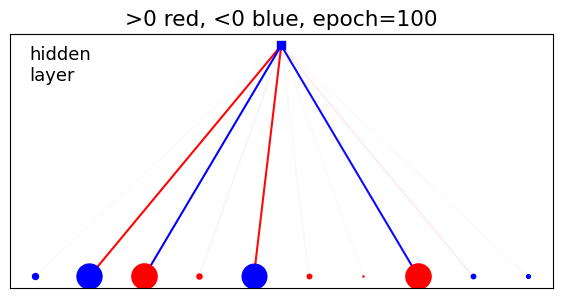

l_rate =  0.5000000000000009
w= [[-0.11818802  0.27651807]
 [-0.29989808 -0.32085104]
 [ 1.13494394  0.80448323]
 [ 0.05364039  0.16266622]
 [ 0.44399539  0.71962943]
 [ 0.58150105 -0.74837361]
 [ 0.15876649  0.13216291]
 [ 0.7811069   0.51178022]
 [-1.15564584 -0.21468339]
 [ 0.96361221 -0.25320836]]
a= [-3.11619869e-01  2.75387424e-01  1.87577865e+00 -5.89605986e-01
 -3.33181510e-01  7.16614519e-02  1.74714021e-01  3.02399945e-01
  5.42869627e-04  7.75848946e-01]
b= [0. 0.]
----------- epoch = 0   k= 499   m= 500
dw = [[-0.026 -0.002]
 [-0.038 -0.046]
 [-0.472 -0.326]
 [ 0.022  0.036]
 [-0.2   -0.138]
 [-0.054 -0.044]
 [-0.148 -0.124]
 [-0.268 -0.186]
 [ 0.028  0.076]
 [-0.336 -0.262]]
da = [ 0.058  0.052 -0.472  0.108 -0.1    0.004 -0.092 -0.234  0.15  -0.302]
db = [-0.168 -0.078]
----------- epoch = 1   k= 499   m= 500
dw = [[-0.01980198 -0.02376238]
 [ 0.02376238  0.05742574]
 [ 0.          0.00594059]
 [ 0.01188119  0.04158416]
 [ 0.01584158  0.01782178]
 [-0.0019802   0.02376238

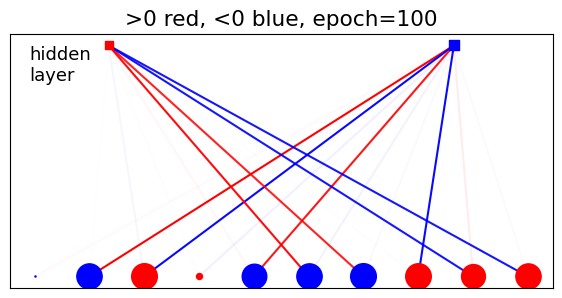

l_rate =  0.5000000000000009
w= [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a= [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b= [0. 0. 0.]
----------- epoch = 0   k= 499   m= 500
dw = [[ 0.042  0.042  0.086]
 [-0.082 -0.154 -0.06 ]
 [ 0.152  0.152  0.084]
 [ 0.058  0.048  0.06 ]
 [-0.044 -0.07  -0.058]
 [ 0.    -0.048 -0.022]
 [ 0.098  0.034  0.044]
 [-0.198 -0.252 -0.19 ]
 [ 0.052  0.084  0.114]
 [-0.192 -0.204 -0.11 ]]
da = [ 0.098 -0.118  0.236  0.10

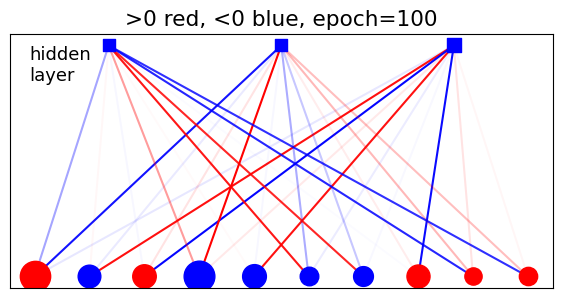

l_rate =  0.5000000000000009
w= [[-1.09420847e-01  2.56005983e-01 -2.77651672e-01 -2.97050343e-01]
 [ 1.05075391e+00  7.44806747e-01  4.96613490e-02  1.50599653e-01]
 [ 4.11059853e-01  6.66247391e-01  5.38365357e-01 -6.92859327e-01]
 [ 1.46989211e-01  1.22359081e-01  7.23164467e-01  4.73816413e-01]
 [-1.06992015e+00 -1.98758197e-01  8.92131554e-01 -2.34425385e-01]
 [-2.88503938e-01  2.54959213e-01  1.73663357e+00 -5.45869073e-01]
 [-3.08466139e-01  6.63456126e-02  1.61753753e-01  2.79967947e-01]
 [ 5.02599612e-04  7.18296549e-01 -3.81405303e-01 -4.44270254e-01]
 [-1.26694211e+00 -9.94618479e-01 -4.60094183e-01  2.99410253e-01]
 [-6.76670449e-01  6.40502923e-02 -5.68471315e-01  1.77933296e-01]]
a= [-1.2611624  -0.1066602  -0.82423128 -0.51888017 -0.69863706  0.15306038
  0.20204101 -0.4029693   0.17707963  0.72146756]
b= [0. 0. 0. 0.]
----------- epoch = 0   k= 499   m= 500
dw = [[ 0.076  0.198  0.214  0.148]
 [-0.142 -0.194 -0.166 -0.084]
 [-0.066 -0.056 -0.074  0.018]
 [-0.072 -0.074 

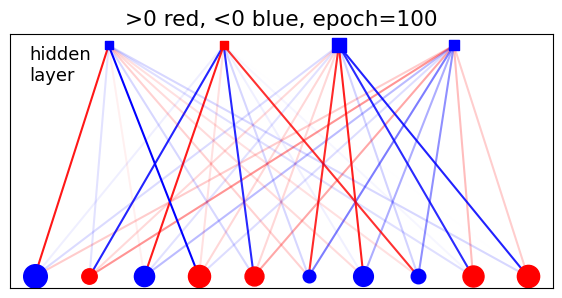

l_rate =  0.5000000000000009
w= [[-1.05710581e-01  2.47325276e-01 -2.68236999e-01 -2.86977895e-01
   1.01512472e+00]
 [ 7.19551678e-01  4.79774212e-02  1.45493088e-01  3.97121546e-01
   6.43656130e-01]
 [ 5.20110348e-01 -6.69365702e-01  1.42005069e-01  1.18210102e-01
   6.98643250e-01]
 [ 4.57750143e-01 -1.03364106e+00 -1.92018661e-01  8.61880964e-01
  -2.26476438e-01]
 [-2.78721284e-01  2.46314000e-01  1.67774743e+00 -5.27359626e-01
  -2.98006602e-01]
 [ 6.40959511e-02  1.56268971e-01  2.70474733e-01  4.85557355e-04
   6.93940393e-01]
 [-3.68472529e-01 -4.29205842e-01 -1.22398236e+00 -9.60892739e-01
  -4.44493209e-01]
 [ 2.89257786e-01 -6.53725760e-01  6.18784611e-02 -5.49195467e-01
   1.71899895e-01]
 [-1.21839863e+00 -1.03043539e-01 -7.96283067e-01 -5.01285870e-01
  -6.74947519e-01]
 [ 1.47870374e-01  1.95190156e-01 -3.89305333e-01  1.71075174e-01
   6.97003882e-01]]
a= [ 0.03608417  0.12738196 -0.0061253   0.51888247  0.68536035 -0.47470463
 -0.79995512  0.01145608  0.39161704 -0.3

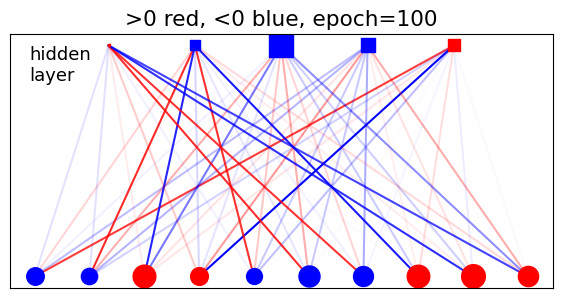

l_rate =  0.5000000000000009
w= [[-1.02353830e-01  2.39471669e-01 -2.59719358e-01 -2.77865152e-01
   9.82890286e-01  6.96702916e-01]
 [ 4.64539384e-02  1.40873076e-01  3.84511284e-01  6.23217368e-01
   5.03594679e-01 -6.48110555e-01]
 [ 1.37495817e-01  1.14456439e-01  6.76458418e-01  4.43214670e-01
  -1.00081865e+00 -1.85921269e-01]
 [ 8.34512655e-01 -2.19284868e-01 -2.69870723e-01  2.38492505e-01
   1.62447196e+00 -5.10613762e-01]
 [-2.88543652e-01  6.20606378e-02  1.51306781e-01  2.61886034e-01
   4.70138888e-04  6.71904897e-01]
 [-3.56771993e-01 -4.15576769e-01 -1.18511583e+00 -9.30380394e-01
  -4.30378699e-01  2.80072647e-01]
 [-6.32967246e-01  5.99135623e-02 -5.31756224e-01  1.66441358e-01
  -1.17970940e+00 -9.97714777e-02]
 [-7.70997764e-01 -4.85367956e-01 -6.53515125e-01  1.43174874e-01
   1.88992055e-01 -3.76943267e-01]
 [ 1.65642825e-01  6.74871107e-01  3.49383444e-02  1.23337055e-01
  -5.93080054e-03  5.02405795e-01]
 [ 6.63597307e-01 -4.59630779e-01 -7.74553219e-01  1.109229

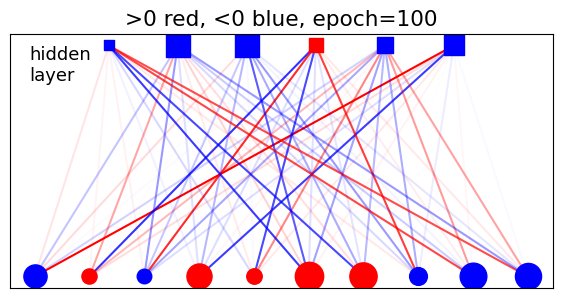

l_rate =  0.5000000000000009


In [5]:
mvals = np.arange(1,7)
# M=1 needs a different coordinate creation
# bc we get a division by 0 otherwise
for m in mvals:    
    # train RBM, show only last plot (at epoch==100)
    run_RBM(data, M=m, showIntermediatePlots=False)  

## 4.4
for M=3, plot $\mathscr{L}$ as a function of “t”, comparing the two contrastive divergence cases (n=1 and n=5). Then, for n=1, plot $\mathscr{L}$ as a function of “t”, comparing the two cases with different M.

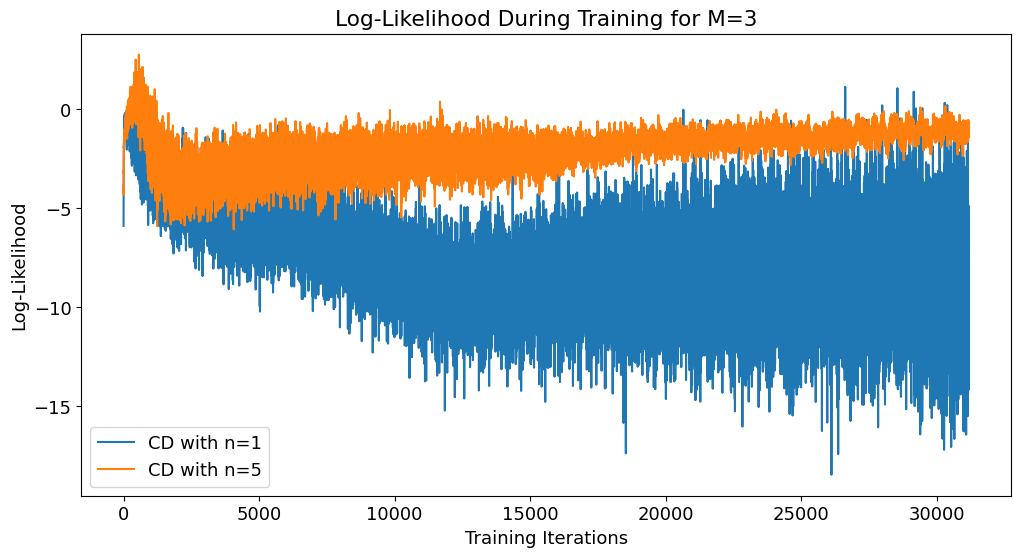

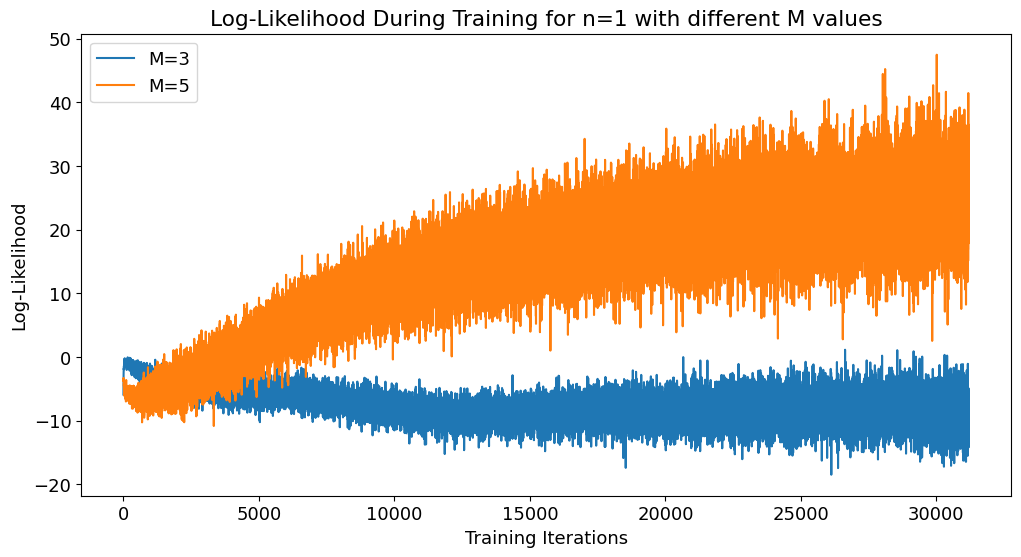

In [6]:
def simulate_rbm(N_visible, N_hidden, num_CD_steps, epochs, batch_size, data):
    W = np.random.randn(N_visible, N_hidden)
    b_visible = np.zeros(N_visible)
    b_hidden = np.zeros(N_hidden)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def log_likelihood(data, W, b_visible, b_hidden):
        energy = np.sum(-np.dot(data, b_visible)[:, np.newaxis] - np.log(1 + np.exp(np.dot(data, W) + b_hidden)), axis=1)
        return np.mean(energy)

    def CD_train(data, W, b_visible, b_hidden, learning_rate=0.1, k=1):
        num_data = len(data)
        positive_hidden = sigmoid(np.dot(data, W) + b_hidden)
        positive_associations = np.dot(data.T, positive_hidden)
        negative_visible = np.random.binomial(1, sigmoid(np.dot(positive_hidden, W.T) + b_visible))
        for i in range(k):
            negative_hidden = sigmoid(np.dot(negative_visible, W) + b_hidden)
            negative_visible = np.random.binomial(1, sigmoid(np.dot(negative_hidden, W.T) + b_visible))
        negative_associations = np.dot(negative_visible.T, negative_hidden)
        W += learning_rate * ((positive_associations - negative_associations) / num_data)
        b_visible += learning_rate * np.mean(data - negative_visible, axis=0)
        b_hidden += learning_rate * np.mean(positive_hidden - negative_hidden, axis=0)

    log_likelihoods = []

    for epoch in range(epochs):
        np.random.shuffle(data)
        for batch_idx in range(len(data) // batch_size):
            batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            CD_train(batch_data, W, b_visible, b_hidden, k=num_CD_steps)
            ll = log_likelihood(batch_data, W, b_visible, b_hidden)
            log_likelihoods.append(ll)
    
    return log_likelihoods


# Simulate for n=1 and n=5 with M=3
log_likelihoods_n1 = simulate_rbm(N_visible=10, N_hidden=3, num_CD_steps=1, epochs=100, batch_size=32, data=data)
log_likelihoods_n5 = simulate_rbm(N_visible=10, N_hidden=3, num_CD_steps=5, epochs=100, batch_size=32, data=data)

# Plot log-likelihood as a function of training iterations for n=1 and n=5
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods_n1, label='CD with n=1')
plt.plot(log_likelihoods_n5, label='CD with n=5')
plt.xlabel('Training Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During Training for M=3')
plt.legend()
plt.show()

# Simulate for different values of M with n=1
log_likelihoods_M3 = log_likelihoods_n1  # Already simulated for M=3, n=1
log_likelihoods_M5 = simulate_rbm(N_visible=10, N_hidden=5, num_CD_steps=1, epochs=100, batch_size=32, data=data)

# Plot log-likelihood as a function of training iterations for M=3 and M=5 with n=1
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods_M3, label='M=3')
plt.plot(log_likelihoods_M5, label='M=5')
plt.xlabel('Training Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During Training for n=1 with different M values')
plt.legend()
plt.show()

## 4.5
From the weights learned by the RBM, guess the structure of the data.

To compute $\mathscr{L}$ , consider full configurations x=(v,h) and their energy E(x). With $\mathscr{L}$ visible units and M hidden units, we have 2L+M possible configurations. The partition function Z is the sum of all their Boltzmann weights e-E(x). The average expectation of the energy according to data is computed by averaging the energy of each data sample vn completed with all 2M possible hidden states. Thus, in total there are N*2M configurations to use in the <E>data average.

The package `itertools` is useful for generating the possible configurations.
https://docs.python.org/3/library/itertools.html
```python
Q=4
import itertools as it
conf = it.product((0,1), repeat=Q)
all_conf=list(conf)
for x in all_conf:
print(x)
```